1.1 Getting Correspondences

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image as PILImage
from moviepy.editor import VideoFileClip

In [2]:
def get_top_matches(frame1, frame2, num_matches=50):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(frame1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(frame2, None)

    # Match descriptors using KNN with ratio test
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.577 * n.distance:
            good_matches.append(m)

    # Select the top matches based on the smallest distance
    good_matches = sorted(good_matches, key=lambda x: x.distance)[:num_matches]
    src_points = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    # Draw the top matches on the frames
    result_img = cv2.drawMatches(frame1, keypoints1, frame2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Return the matches and the result image
    return  result_img, src_points, dst_points


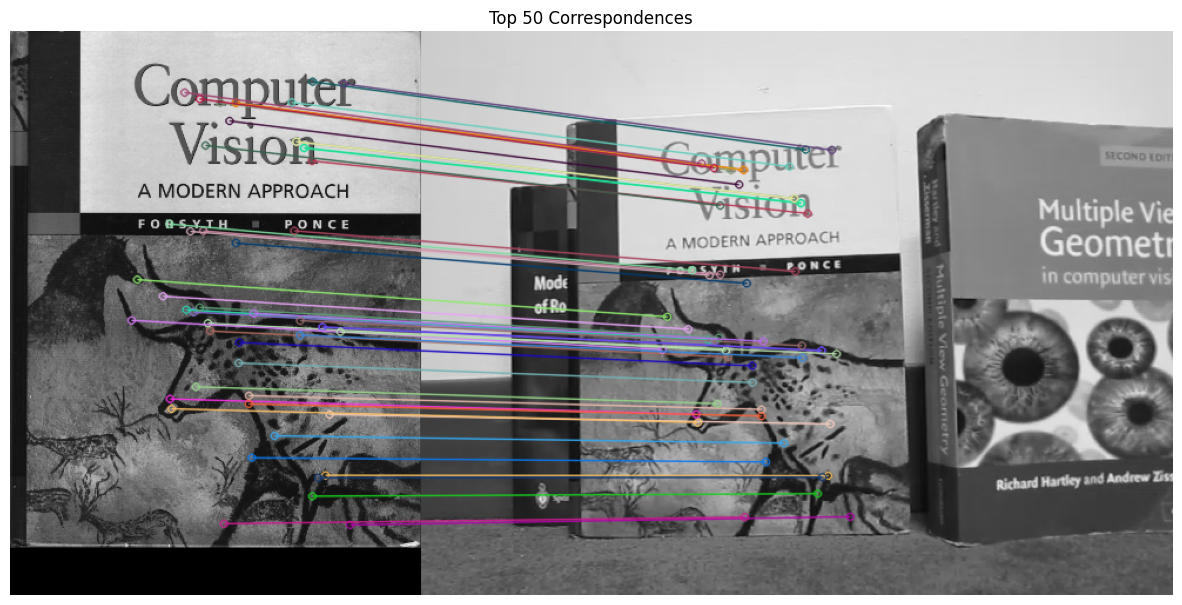

In [3]:

# Paths to the videos and book image
ar_video_path = r'.\assignment_2_materials\ar_source.mov'
book_video_path = r'.\assignment_2_materials\book.mov'
book_image_path = r'\assignment_2_materials\cv_cover.jpg'

# Load the book image
book_img = cv2.imread(book_image_path, cv2.IMREAD_GRAYSCALE)

# Open the book video and read the first frame
book_video = cv2.VideoCapture(book_video_path)
ret, book_frame = book_video.read()
if not ret:
    print("Error: Unable to read the first frame of the book video.")
    exit()
book_frame_gray = cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)

result_img, src_points, dst_points=get_top_matches(book_img,book_frame_gray,50)

# Display the matches
plt.figure(figsize=(15, 10))
plt.imshow(result_img)
plt.title("Top 50 Correspondences")
plt.axis("off")
plt.show()

# Release the video
book_video.release()


1.2 Compute the Homography Parameters

In [4]:
def compute_homography(src_points, dst_points):
    A = []
    for i in range(len(src_points)):
        x, y = src_points[i]
        x_prime, y_prime = dst_points[i]
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H / H[2, 2]

# Compute homography
H = compute_homography(src_points, dst_points)

print("Homography Matrix:\n", H)


Homography Matrix:
 [[ 7.72294774e-01  4.41235467e-03  1.19497740e+02]
 [-5.19380140e-02  7.79667787e-01  7.75663379e+01]
 [-9.42457969e-05 -6.99072751e-05  1.00000000e+00]]


In [5]:

# Function to map points using the homography matrix
def map_points(H, points):
    # Convert to homogeneous coordinates
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    mapped_points = H @ points_homogeneous.T
    # Convert back to 2D
    mapped_points /= mapped_points[2]
    return mapped_points[:2].T

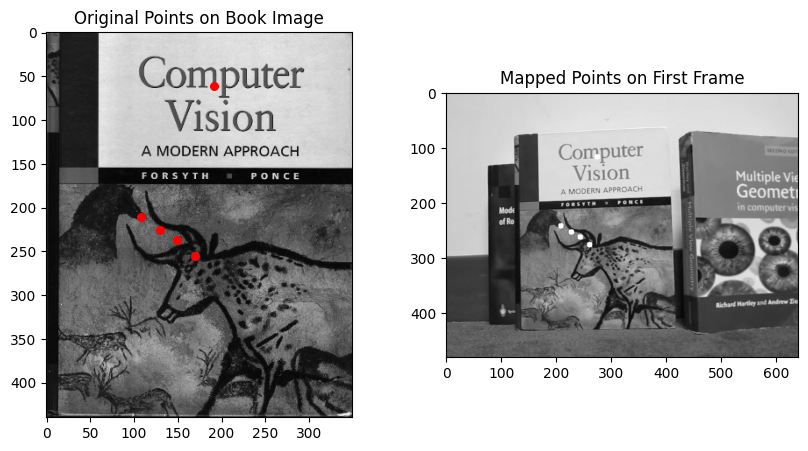

In [6]:
# Select a few points to test the homography
test_src_points = src_points[:5]  # Select the first 5 points for testing
mapped_points = map_points(H, test_src_points)

# Visualize the original points and mapped points on the destination image
frame_with_points = book_frame_gray.copy()
for pt in mapped_points:
    cv2.circle(frame_with_points, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(book_img, cmap='gray')
plt.title("Original Points on Book Image")
for pt in test_src_points:
    plt.scatter(pt[0], pt[1], color='red', s=30)
    
plt.subplot(1, 2, 2)
plt.imshow(frame_with_points, cmap='gray')
plt.title("Mapped Points on First Frame")
plt.show()


In [7]:

# Verify by comparing distances between corresponding points
test_dst_points = dst_points[:5]
distance_error = np.linalg.norm(mapped_points - test_dst_points, axis=1)
print("Distance Errors between Mapped Points and True Points:\n", distance_error)
print("Mean Error:", np.mean(distance_error))


Distance Errors between Mapped Points and True Points:
 [0.41334279 0.25629685 0.1824111  0.20593388 0.20335326]
Mean Error: 0.2522675775007053


1.3 Calculate Book Coordinates

In [8]:
def compute_corners(book_img, H):
    # Get the height and width of the book image
    h, w = book_img.shape[:2]
    
    # Define the corners of the book image (top-left, top-right, bottom-right, bottom-left)
    book_corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
    
    mapped_corners = map_points(H, book_corners)
    
    return mapped_corners

In [9]:

# Get the mapped corners
mapped_corners = compute_corners(book_img, H)

# Print the mapped corners
print("Mapped Corners:", mapped_corners)


Mapped Corners: [[119.4977395   77.56633794]
 [403.0974961   61.41383145]
 [418.4142597  429.84225252]
 [125.29309093 433.96869452]]


Test Corners

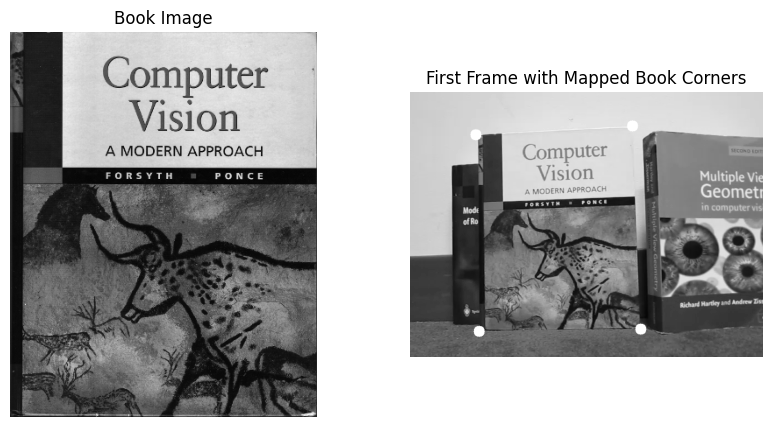

In [10]:

#Draw the mapped corners on the first frame
frame_with_corners = book_frame_gray.copy()
for pt in mapped_corners:
    cv2.circle(frame_with_corners, (int(pt[0]), int(pt[1])), 10, (255, 255, 255), -1)

# Visualize the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(book_img, cmap='gray')
plt.title("Book Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(frame_with_corners, cmap='gray')
plt.title("First Frame with Mapped Book Corners")
plt.axis('off')

plt.show()

1.4 Crop AR Video Frames

In [11]:
def calculate_crop_regions(frame, mapped_corners):
    # Get the height and width of the frame
    height, width = frame.shape[:2]

    # Check if the frame has enough height to crop
    if height <= 88:
        raise ValueError("The frame height is too small to crop the specified number of pixels.")

    # Crop the frame to remove black regions (top and bottom)
    cropped_frame = frame[44:height - 44, :]

    # Calculate the bounding box for the book region from the mapped corners
    # Adjust the indexing based on the shape of mapped_corners
    x_min = np.min(mapped_corners[:, 0])  # Accessing as 2D array
    y_min = np.min(mapped_corners[:, 1])
    x_max = np.max(mapped_corners[:, 0])
    y_max = np.max(mapped_corners[:, 1])

    # Calculate book width and height
    book_width = int(x_max - x_min)
    book_height = int(y_max - y_min)

    # Calculate the cropping region for the left and right sides of the frame
    x_crop_start = int((width - book_width) // 2)
    x_crop_end = int(x_crop_start + book_width)

    # Ensure the crop does not exceed frame dimensions
    x_crop_start = max(0, x_crop_start)
    x_crop_end = min(width, x_crop_end)

    # Crop the frame to fit the book width
    cropped_frame = cropped_frame[:, x_crop_start:x_crop_end]

    return cropped_frame

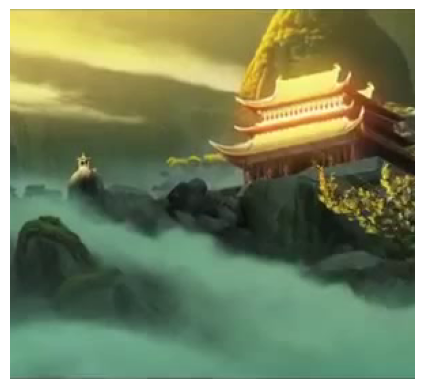

In [12]:
# Open the book video and read the first frame
ar_video_path = r'.\assignment_2_materials\ar_source.mov'
ar_video = cv2.VideoCapture(ar_video_path)
ret, ar_frame = ar_video.read()
if not ret:
    print("Error: Unable to read the first frame of the book video.")
    exit()
frame=calculate_crop_regions(ar_frame,mapped_corners)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

In [ ]:



# Create a directory to save the frames
output_dir = r'\assignment_2_materials\frames_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open the video file
cap = cv2.VideoCapture(r'.\assignment_2_materials\ar_source.mov')

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read the first frame to calculate the cropping region
ret, first_frame = cap.read()
if not ret:
    print("Error: Unable to read the first frame.")
    exit()

# Create a directory to save the frames
frame_count = 0
while True:
    ret, frame = cap.read()

    # Break if no frame is read (end of video)
    if not ret:
        break
    cropped_frame=calculate_crop_regions(frame, mapped_corners)
    
    # Convert the cropped frame to RGB (to fix the color channel issue)
    cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)

    # Convert the frame to a PIL Image
    pil_img = PILImage.fromarray(cropped_frame_rgb)

    # Save the frame as an image
    frame_filename = os.path.join(output_dir, f'frame_{frame_count + 1}.jpg')
    pil_img.save(frame_filename)
    print(f'Saved {frame_filename}')

    frame_count += 1

# Release the video capture object
cap.release()


1.5 Overlay the First Frame of the Two Videos

In [ ]:
def overlay_frames(ar_frame, book_frame, mapped_corners):
    # Crop the AR frame using the mapped corners
    cropped_frame = calculate_crop_regions(ar_frame, mapped_corners)
    
    # Get the height and width of the cropped frame
    h, w = cropped_frame.shape[:2]
    
    # Get the height and width of the book frame
    frame_height, frame_width, _ = book_frame.shape
    
    # Define the destination coordinates (mapped corners)
    dst_points = np.array(mapped_corners, dtype='float32').reshape(4, 2)  # Ensure the points are of type float32
    
    # Define the source coordinates (corners of the cropped frame)
    src_points = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')  # Ensure the points are of type float32
    
    # Check that both source and destination points have 4 points
    if src_points.shape[0] != 4 or dst_points.shape[0] != 4:
        raise ValueError("Both source and destination points must have exactly 4 points.")
    
    # Compute the Homography transformation matrix
    M = compute_homography(src_points, dst_points)
    
    # Apply the perspective transformation to the cropped frame
    warped_frame = cv2.warpPerspective(cropped_frame, M, (frame_width, frame_height))
    
    # Create a mask for the warped frame
    mask = np.zeros((frame_height, frame_width), dtype=np.uint8)
    
    # Fill the area defined by the coordinates with white (255)
    mapped_corners = np.array(mapped_corners, dtype=np.int32)
    cv2.fillPoly(mask, [mapped_corners], color=255)
    
    # Create an inverse mask for the book frame
    inverse_mask = cv2.bitwise_not(mask)
    
    # Use the mask to overlay the warped frame on the book frame
    book_frame_with_overlay = cv2.bitwise_and(book_frame, book_frame, mask=inverse_mask)
    overlay = cv2.bitwise_and(warped_frame, warped_frame, mask=mask)
    
    # Add the overlay to the book frame
    final_output = cv2.add(book_frame_with_overlay, overlay)
    
    return final_output




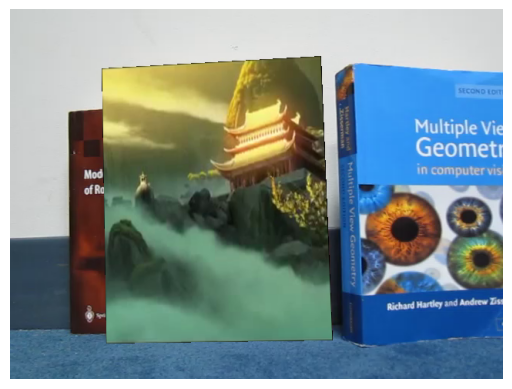

In [15]:
# Example usage
book_video_path = r'.\assignment_2_materials\book.mov'
book_video = cv2.VideoCapture(book_video_path)
ret, book_frame = book_video.read()
book_height, book_width, _ = book_frame.shape

# Open the AR source video file
cap = cv2.VideoCapture(r'.\assignment_2_materials\ar_source.mov')

# Read the first frame of the AR video
ret, first_frame = cap.read()

# Call the function with the first frame of the AR video and the book frame
final_output = overlay_frames(first_frame, book_frame, mapped_corners)

# Display the final result
plt.imshow(cv2.cvtColor(final_output, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

# Release the video capture object
cap.release()
book_video.release()

1.6 Creating AR Application

In [16]:
# Paths to the videos and book image
ar_video_path = r'.\assignment_2_materials\ar_source.mov'
book_video_path = r'.\assignment_2_materials\book.mov'
book_image_path = r'.\assignment_2_materials\cv_cover.jpg'

# Load the book image
book_img = cv2.imread(book_image_path, cv2.IMREAD_GRAYSCALE)

# Open the book video
book_video = cv2.VideoCapture(book_video_path)
ar_video = cv2.VideoCapture(ar_video_path)
frame_width = int(book_video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(book_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(ar_video.get(cv2.CAP_PROP_FPS))

# Define the codec and create a VideoWriter object
output_video_path = r'.\assignment_2_materials\output.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))



In [17]:
def process_frames(book_video, book_img, out):
    frame_idx = 0
    
    while True:

        ret, book_frame = book_video.read()
        if not ret:
            break  # Exit the loop if no more frames in the book video
       
        book_frame_gray = cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY)

        result_img,src_points, dst_points=get_top_matches(book_img,book_frame_gray,22)

        if len(src_points) < 4 or len(dst_points) < 4:
            print(f"Skipping frame {frame_idx} due to insufficient matches.")
            continue

        H = compute_homography(src_points, dst_points)
        mapped_corners = compute_corners(book_img,H)
       
        ret, first_frame = ar_video.read()
        if not ret:
            print(frame_idx)
            break
        book_frame= overlay_frames(first_frame, book_frame, mapped_corners)
               
        out.write(book_frame)
        frame_idx += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


In [18]:
# Main function to call processing
process_frames(book_video, book_img, out)
book_video.release()
out.release()
ar_video.release()
cv2.destroyAllWindows()


511


In [ ]:
# Add the audio from the AR video to the processed video
output_with_audio_path = r'.\assignment_2_materials\output_with_audio.avi'
ar_clip = VideoFileClip(ar_video_path)
processed_clip = VideoFileClip(output_video_path)
final_clip = processed_clip.set_audio(ar_clip.audio)
final_clip.write_videofile(output_with_audio_path, codec="libx264", audio_codec="aac")
